# Lab Report of Group 1 (Wörner, Velez, Northe)

The source code and the binaries from the spectrum analyzer from this report can be found in our Github [repository](https://github.com/NortheLo/Microwave_Eng_Lab/tree/main/Lab4_Noise_Figures).

### Our used imports

In [51]:
import re
import numpy as np
from numpy.typing import NDArray
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.io.matlab import loadmat
from scipy.constants import Boltzmann
from scipy.stats import linregress

### Some helper functions to keep the evaluation code short 

In [52]:
k_B = Boltzmann     # Boltzman constant

def dbm_to_mw(dbm):
    return 10**(dbm / 10)

def read_mat(file_path: str | Path, dic_name: str) -> tuple[NDArray, NDArray, NDArray]:
    """
    Get the Gain, NF and f vector from the signal analyzer matlab file.
    """
    ws = loadmat(file_path)
    ws = ws[dic_name]

    gain = ws['gain'][0, 0].flatten()
    noise = ws['noise'][0, 0].flatten()
    f_steps = ws['f'][0, 0].flatten()

    return gain, noise, f_steps

def read_spec_csv(file_path: Path) -> tuple[list, NDArray, NDArray]:
    """
    Reads the CSV from the Spectrum Analyzer and puts the Metadata in a list, the freq bins and power
    into Numpy Arrays
    """
    # Read the entire CSV file
    with open(file_path, 'r') as f:
        content = f.read()

    # Split content into metadata and data sections using regex to find "DATA"
    parts = re.split(r'\bDATA\b', content)
    
    # Check if "DATA" section was found
    if len(parts) != 2:
        raise ValueError("No DATA section found in the file.")

    metadata_section = parts[0].strip()  # Everything before DATA
    data_section = parts[1].strip()      # Everything after DATA

    # Parse the metadata section
    metadata = {}
    for line in metadata_section.splitlines():
        if ',' in line:
            key, value = line.split(',', 1)
            metadata[key.strip()] = value.strip()

    # Parse the data section (split by newline, then split by comma)
    data = []
    for line in data_section.splitlines():
        if ',' in line:
            try:
                x, y = map(float, line.split(','))
                data.append([x, y])
            except ValueError:
                print(f"Skipping invalid line: {line}")
    
    # Convert data into numpy arrays
    data = np.array(data)
    frequencies = data[:, 0]  # First column (Frequency)
    values = data[:, 1]       # Second column (Values)

    return metadata, frequencies, values

def scientific_2_str(value: float, unit: str = "Ω") -> str:
    prefixes = [
        (1e9, 'G'),
        (1e6, 'M'),
        (1e3, 'k'),
        (1, ''),
        (1e-3, 'm'),
        (1e-6, 'µ'),
        (1e-9, 'n'),
        (1e-12, 'p')
    ]

    for factor, prefix in prefixes:
        if abs(value) >= factor:
            formatted = value / factor
            return f"{formatted:.3g} {prefix}{unit}"
    return f"{value:.3g} {unit}"  # fallback for very small values

def plot_compare(x1: NDArray, y1: NDArray,
                 x2: NDArray, y2: NDArray,
                 title: str,
                 x_label: str="Resistance [Ohm]",
                 y_label: str="Frequency [MHz]",
                 x_log: bool=False,
                 y_log: bool=False,
                 label1: str="Measurement 1",
                 label2: str="Measurement 2",
                 marker1: str='o',
                 marker2: str='s'):
    """
    Plots two datasets (x1, y1) and (x2, y2) on the same plot.
    This function assumes that x1 and x2 are frequency bins and y1 and y2 are the corresponding power bins.
    """
    
    # Align the bins to their corresponding measurements
    plt.figure(figsize=(8, 4))

    # Check if data requires log scaling
    if x_log and y_log:
        plt.loglog(x1, y1, marker=marker1, label=label1)
        plt.loglog(x2, y2, marker=marker2, label=label2)
    elif x_log:
        plt.semilogx(x1, y1, marker=marker1, label=label1)
        plt.semilogx(x2, y2, marker=marker2, label=label2)
    elif y_log:
        plt.semilogy(x1, y1, marker=marker1, label=label1)
        plt.semilogy(x2, y2, marker=marker2, label=label2)
    else:
        plt.plot(x1, y1, marker=marker1, label=label1)
        plt.plot(x2, y2, marker=marker2, label=label2)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot(x: NDArray, 
             y: NDArray,
             title: str,
             x_label: str="Resistance [Ohm]",
             y_label: str="Frequency [Hz]",
             x_log: bool=False,
             y_log: bool=False,
             marker: str='o'):

    plt.figure(figsize=(8, 4))

    if x_log and y_log:
        plt.loglog(x, y, marker=marker)
    elif x_log:
        plt.semilogx(x, y, marker=marker)
    elif y_log:
        plt.semilogy(x, y, marker=marker)
    else:
        plt.plot(x, y, marker=marker)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def compute_and_plot_cascade_with_measured(
    f_lna: NDArray, gain_lna_db: NDArray, nf_lna_db: NDArray,
    f_att: NDArray, gain_att_db: NDArray, nf_att_db: NDArray,
    f_meas: NDArray, gain_meas_db: NDArray, nf_meas_db: NDArray,
    title: str = "5.4 LNA → 6 dB Attenuator: Measured vs Theoretical",
    x_label: str = "$f$ in $[MHz]$", y_label: str = "$P$ in $[dBm]$"
) -> tuple[NDArray, NDArray, NDArray]:
    """
    Plots measured and theoretical NF and gain for the cascade LNA → Attenuator.
    """
    from scipy.interpolate import interp1d

    def db_to_linear(db): return 10**(db / 10)
    def linear_to_db(lin): return 10 * np.log10(lin)

    # Interpolation base: common range across all three datasets
    f_min = max(f_lna.min(), f_att.min(), f_meas.min())
    f_max = min(f_lna.max(), f_att.max(), f_meas.max())
    f_common = np.linspace(f_min, f_max, num=300)

    # Interpolate all to common frequency base
    G1 = db_to_linear(interp1d(f_lna, gain_lna_db, kind='linear', fill_value='extrapolate')(f_common))
    F1 = db_to_linear(interp1d(f_lna, nf_lna_db, kind='linear', fill_value='extrapolate')(f_common))
    G2 = db_to_linear(interp1d(f_att, gain_att_db, kind='linear', fill_value='extrapolate')(f_common))
    F2 = db_to_linear(interp1d(f_att, nf_att_db, kind='linear', fill_value='extrapolate')(f_common))

    # Compute theoretical cascade using Friis
    G_total = G1 * G2
    F_total = F1 + (F2 - 1) / G1

    # Convert to dB
    gain_theo_db = linear_to_db(G_total)
    nf_theo_db = linear_to_db(F_total)

    # Interpolate measured cascade to f_common
    gain_meas_interp = interp1d(f_meas, gain_meas_db, kind='linear', fill_value='extrapolate')(f_common)
    nf_meas_interp = interp1d(f_meas, nf_meas_db, kind='linear', fill_value='extrapolate')(f_common)

    # Plot all four curves
    plt.figure(figsize=(9, 4))
    plt.plot(f_common, gain_meas_interp, label="Gain (Measured)", linestyle='-')
    plt.plot(f_common, nf_meas_interp, label="Noise Figure (Measured)", linestyle='-')
    plt.plot(f_common, gain_theo_db, label="Gain (Theoretical)", linestyle='--')
    plt.plot(f_common, nf_theo_db, label="Noise Figure (Theoretical)", linestyle='--')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return f_common, gain_theo_db, nf_theo_db


### Overview of Measurement Files
Files can be found under ``Meassurements/``

| File Name                     | Description                                       |
|------------------------------|---------------------------------------------------|
| `meassurement_5_1.mat`       | NF measurement of a filter         |
| `meassurement_5_2.mat`       | NF measurement of an attenuator                   |
| `meassurement_5_3.mat`       | NF measurement of LNA     |
| `meassurement_5_4.mat`       | NF of LNA → Attenuator |
| `meassurement_5_4_inverse.mat` | NF of Attenuator → LNA |


### CSV-File Overview
Files can be found under ``Meassurements/``
| Filename            | Description            |
|---------------------|------------------------|
| `SNS_Cold_Cal.csv`   | no DUT + no NS         |
| `SNS_Hot_Cal.csv`   | no DUT + NS            |
| `SNS_Cold.csv`   | DUT + no NS            |
| `SNS_Hot.csv`   | DUT + NS               |

## 5.1 Filter

We calculated the results below with some Python code.

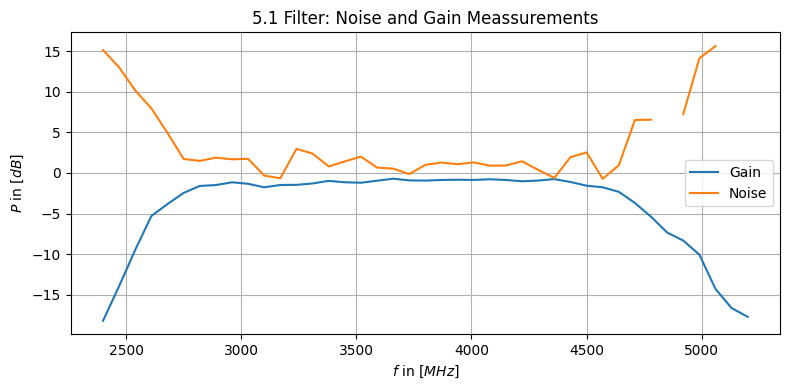

In [53]:
title_filter = "5.1 Filter: Noise and Gain Meassurements"
filter_gain, filter_noise, filter_f_steps = read_mat('Meassurements/meassurement_5_1.mat', 'messung_5_1_filter')


plot_compare(x1=filter_f_steps, y1=filter_gain,
             x2=filter_f_steps, y2=filter_noise,
             title=title_filter, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[MHz]$",
             y_label="$P$ in $[dB]$")

In [54]:
# search all the indices which are below our 3dB threshold
# and then search for the last and the first one
peak_gain = np.max(filter_gain)
threshold = peak_gain - 3

crossing_indices = np.where(filter_gain <= threshold)[0]

if crossing_indices.size >= 2:
    peak_index = np.argmax(filter_gain)
    
    lower_idx = crossing_indices[crossing_indices < peak_index][-1]
    f1, f2 = filter_f_steps[lower_idx], filter_f_steps[lower_idx + 1]
    g1, g2 = filter_gain[lower_idx], filter_gain[lower_idx + 1]
    f_3db_low = f1 + (threshold - g1) * (f2 - f1) / (g2 - g1)

    upper_idx = crossing_indices[crossing_indices > peak_index][0]
    f1, f2 = filter_f_steps[upper_idx - 1], filter_f_steps[upper_idx]
    g1, g2 = filter_gain[upper_idx - 1], filter_gain[upper_idx]
    f_3db_high = f1 + (threshold - g1) * (f2 - f1) / (g2 - g1)
    f_center = (f_3db_high - f_3db_low) / 2 + f_3db_low

    print(f"Lower -3 dB frequency: {f_3db_low:.2f} MHz")
    print(f"Upper -3 dB frequency: {f_3db_high:.2f} MHz")
    print(f"Estimated center frequency: {f_center:.2f} MHz")
else:
    print("Could not find two -3 dB crossing points.")



Lower -3 dB frequency: 2686.30 MHz
Upper -3 dB frequency: 4710.45 MHz
Estimated center frequency: 3698.38 MHz


In [55]:
# we divide as we have steps normed to MHz 
f_min = 3e9 / 1e6
f_max = 4.3e9 / 1e6 

mask = (filter_f_steps >= f_min) & (filter_f_steps <= f_max)
gain_in_band = filter_gain[mask]

if gain_in_band.size > 0:
    gain_max = np.max(gain_in_band)
    gain_min = np.min(gain_in_band)
    ripple = gain_max - gain_min

    print(f"Transmission ripple between 3 GHz and 4.3 GHz: {ripple:.2f} dB")
else:
    print("No data points found in the 3 GHz to 4.3 GHz range.")

Transmission ripple between 3 GHz and 4.3 GHz: 1.06 dB


## 5.2 Attenuator (6 dB)

The frequency response of the 6 dB attenuator is shown in Figure 2. As expected for a passive, linear component, both the gain and the noise figure are nearly constant across the measured frequency range of 200 MHz to 6 GHz. The measured gain is approximately –6 dB throughout, closely matching the nominal attenuation value of the device. Hence:

$$
G = -6 \text{dB}
$$

From a theoretical standpoint, for a passive network at ambient temperature $T \approx T_0 = 290\,\text{K}$, the noise figure is given by:

$$
F = 1 + (L - 1)\frac{T}{T_0}
$$

where $L$ is the linear loss. At $T = T_0$, this simplifies to $F = L$, and in dB:

$$
F_{\text{dB}} = L_{\text{dB}} = 6\,\text{dB}
$$

The experimental results confirm this theoretical expectation. The gain remains consistently around –6 dB across the entire frequency sweep, and the noise figure is likewise flat, averaging close to 6 dB. This behavior is characteristic of a broadband, resistive attenuator, which introduces thermal noise equivalent to its loss when matched and operated at room temperature.


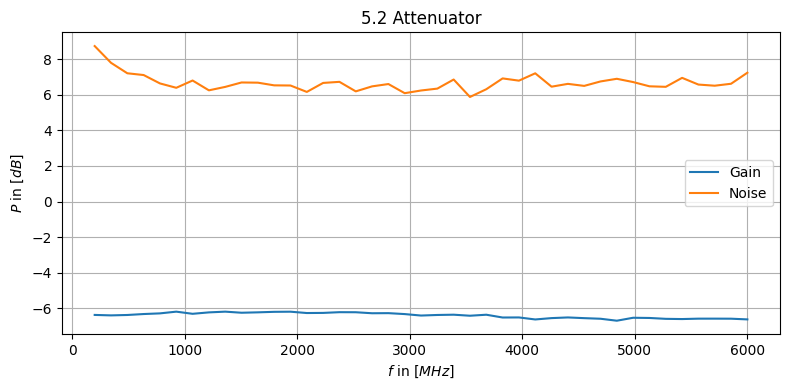

In [56]:
title_att = "5.2 Attenuator"
att_gain, att_noise, att_f_steps  = read_mat('Meassurements/meassurement_5_2.mat', 'messung_5_2_att')

plot_compare(x1=att_f_steps, y1=att_gain,
             x2=att_f_steps, y2=att_noise,
             title=title_att, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[MHz]$",
             y_label="$P$ in $[dB]$")

## 5.3 Low noise amplifier (LNA)

Task asks for the frequency at which the LNA produces max gain and at which frequency the NF is minimal. The solution is below the plot.

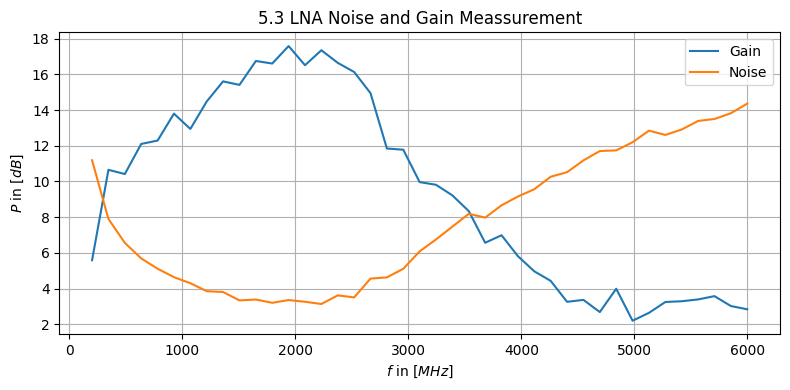

In [57]:
title_lna = "5.3 LNA Noise and Gain Meassurement"
lna_gain, lna_noise, lna_f_steps = read_mat('Meassurements/meassurement_5_3.mat', 'messung_5_3_LNA')


plot_compare(x1=lna_f_steps, y1=lna_gain,
             x2=lna_f_steps, y2=lna_noise,
             title=title_lna, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[MHz]$",
            y_label="$P$ in $[dB]$")

In [58]:
max_gain = np.max(lna_gain)
f_max_gain = lna_f_steps[np.argmax(lna_gain)]
print(f"LNA gain is max @ {f_max_gain} MHz with {max_gain:.2f} dB")

min_noise = np.min(lna_noise)
f_min_noise = lna_f_steps[np.argmin(lna_noise)]
print(f"LNA noise is min @ {f_min_noise} MHz with {min_noise:.2f} dB")


LNA gain is max @ 1940 MHz with 17.59 dB
LNA noise is min @ 2230 MHz with 3.13 dB


## 5.4 LNA with subsequent 6 dB attenuator

#### LNA Followed by Attenuator

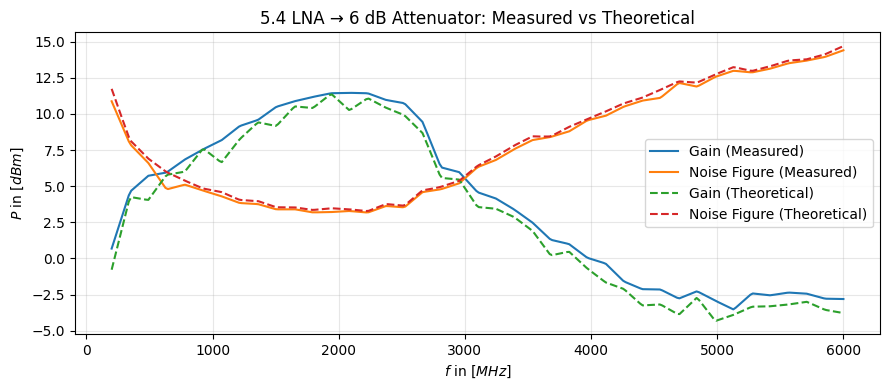

In [59]:
title_lna_att = "5.4 LNA -> $6$dB Attenuator"
lna_att_gain, lna_att_noise, lna_att_f_steps = read_mat('Meassurements/meassurement_5_4.mat', 'messung_5_4_LNA_Att')

# Compute and plot all (We parse the signals of LNA and att in the way defined for the function)
f_plot, gain_theo, nf_theo = compute_and_plot_cascade_with_measured(
    f_lna=lna_f_steps, gain_lna_db=lna_gain, nf_lna_db=lna_noise,
    f_att=att_f_steps, gain_att_db=att_gain, nf_att_db=att_noise,
    f_meas=lna_att_f_steps, gain_meas_db=lna_att_gain, nf_meas_db=lna_att_noise
)

In this configuration, the low-noise amplifier (LNA) is followed by a 6 dB attenuator. The measured gain is consistent with theoretical expectations: compared to the standalone LNA (Section 5.3), the gain curve is approximately 6 dB lower, as expected from adding a fixed attenuator after the amplifier.

To estimate the theoretical noise figure of the cascade, we apply the **Friis formula** for two components:

$$
F_{\text{total}} = F_1 + \frac{F_2 - 1}{G_1}
$$

Where:
- $F_1$: noise factor of the LNA (converted from NF in dB)
- $F_2$: noise factor of the attenuator
- $G_1$: gain of the LNA (linear)
---

This is automatically handled by the snippet that generates the comparison plot. The following points about the gain and noise figure are worth mentioning:

#### Gain

- The measured gain closely resembles the theoretical prediction, with a small deviation of approximately 0.5 to 1 dB at higher frequencies.
- This minor difference could be attributed to:
  - Connector losses
  - Cable losses
- The overall gain shape and roll-off behavior are well preserved, demonstrating that the theoretical cascade model correctly reflects the behavior of the actual system.

---

#### Noise Figure

- The **noise figure** shows very good agreement between the measured and calculated curves throughout most of the frequency range.
- Both curves confirm that the NF remains low and stable (~4–6 dB) in the mid-band, where the LNA operates with maximum effectiveness.
- Slight divergence at the higher-frequency end may be caused by:
  - Temperature variations
  - Measurement uncertainty
  - Random behavior of noise

---

#### Attenuator Followed by LNA

In contrast, when the attenuator is placed before the LNA, the overall system gain remains roughly the same, but the noise figure is significantly higher, especially at higher frequencies.

This behavior is predicted by the Friis formula:

$$
F_{\text{swapped}} = F_2 + \frac{F_1 - 1}{G_2}
$$

Here, $F_2$ is now the dominant term, since it comes first. The LNA still amplifies the signal and noise, but the attenuator has already degraded the SNR by introducing thermal noise and reducing signal power. The result is a higher system noise figure, as seen in the plot, particularly because the first component in the chain dominates the overall noise performance. This is observed when plotting the following:

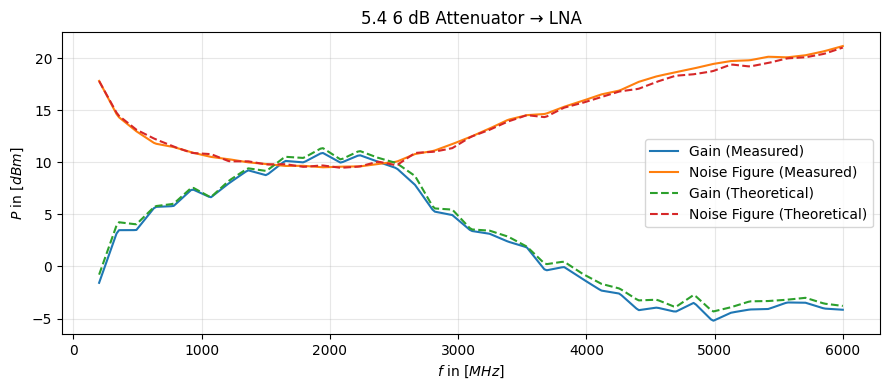

In [60]:
title_att_lna = "5.4 6 dB Attenuator → LNA"
att_lna_gain, att_lna_noise , att_lna_f_steps = read_mat(
    'Meassurements/meassurement_5_4_inverse.mat', 
    'messung_5_4_LNA_Att_reverse'
)

# Compute and plot theoretical + measured for: Attenuator → LNA (We switch the order of parsing the combined parameters)
f_plot_rev, gain_theo_rev, nf_theo_rev = compute_and_plot_cascade_with_measured(
    f_lna=att_f_steps, gain_lna_db=att_gain, nf_lna_db=att_noise,
    f_att=lna_f_steps, gain_att_db=lna_gain, nf_att_db=lna_noise,
    f_meas=att_lna_f_steps, gain_meas_db=att_lna_gain, nf_meas_db=att_lna_noise,
    title=title_att_lna
)

Analogous to the previous case, it is worth mentioning:

#### Gain

- The measured gain closely matches the theoretical prediction, validating the cascade model.
- In this configuration, overall gain is the same as for the previous case where the LNA was placed before the attenuator.

---

#### Noise Figure

- The noise figure is significantly worse than in the LNA → Attenuator configuration.
- Both theoretical and measured NF increase sharply with frequency, reaching values above $20 dB$.
- This behavior confirms the theoretical expectation from the Friis formula: placing the component with the higher noise figure at the front of the chain amplifies its negative effect on the overall noise performance.

### Comparison: Impact of component ordering

The following plot compares the total **gain** and **noise figure** of two cascaded configurations:

- **LNA → Attenuator**
- **Attenuator → LNA**

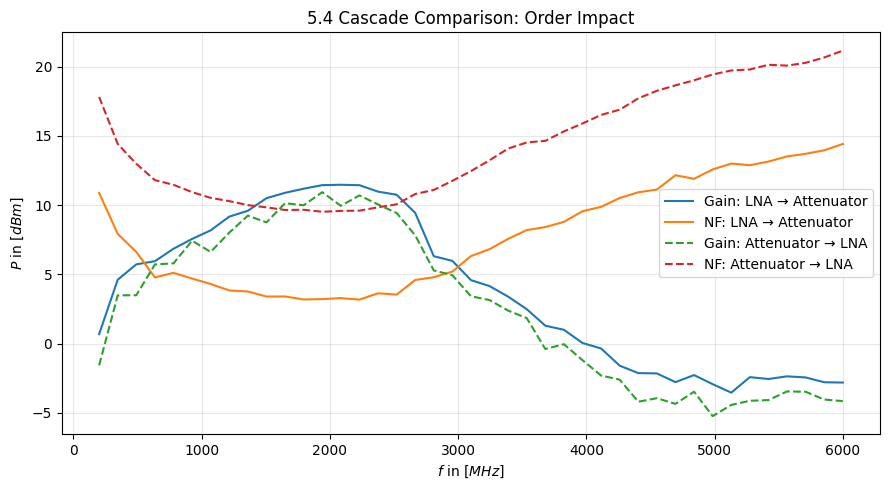

In [61]:
def plot_cascade_comparison(
    f1: NDArray, gain1: NDArray, nf1: NDArray,
    f2: NDArray, gain2: NDArray, nf2: NDArray,
    label_gain1: str = "Gain: LNA → Attenuator",
    label_nf1: str = "NF: LNA → Attenuator",
    label_gain2: str = "Gain: Attenuator → LNA",
    label_nf2: str = "NF: Attenuator → LNA",
    title: str = "5.4 Cascade Comparison: Order Impact",
    x_label: str = "$f$ in $[MHz]$", y_label: str = "$P$ in $[dBm]$",
    linestyle1: str = '-', linestyle2: str = '--'
):
    plt.figure(figsize=(9, 5))

    # Plot LNA → Attenuator
    plt.plot(f1, gain1, linestyle=linestyle1, label=label_gain1)
    plt.plot(f1, nf1, linestyle=linestyle1, label=label_nf1)

    # Plot Attenuator → LNA
    plt.plot(f2, gain2, linestyle=linestyle2, label=label_gain2)
    plt.plot(f2, nf2, linestyle=linestyle2, label=label_nf2)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_cascade_comparison(
    f1=lna_att_f_steps, gain1=lna_att_gain, nf1=lna_att_noise,
    f2=att_lna_f_steps, gain2=att_lna_gain, nf2=att_lna_noise,
    linestyle1='-', linestyle2='--'
)

#### Gain Behavior

- When the LNA is placed before the attenuator, the signal is amplified first, then attenuated.
- In the Attenuator → LNA configuration, the signal is attenuated before amplification.
Overall the gain from both measurements yield approximatelly the same gain value as observed above, since this operation equals adding the dB value of the two gains the result is not altered by the components order.

---

#### Noise Figure Behavior

- With the LNA first, the noise figure remains relatively low, with a minimum of almost 4dB at 2000 MHz, especially across the central bandwidth. This reflects the LNA’s role in preserving the signal-to-noise ratio (SNR) early in the chain.
- Conversely, in the Attenuator followed by the LNA case, the system exhibits a much higher noise figure, particularly at higher frequencies. The attenuator introduces thermal noise and reduces the signal before the LNA can amplify it, which causes significant degradation in SNR. The noise figure climbs to over 15 dB in some regions.

---

## 5.5 Noise figure measurement of the LNA with Y-Factor method

The following cell should load in the CSV file from the meassuring device. The evaluation is below the code and plots.

In [62]:
meta_data_cold_cal, f_steps_n1, N_1 = read_spec_csv("Meassurements/SNS_Cold_Cal.csv")
meta_data_hot_cal, f_steps_n2, N_2 = read_spec_csv("Meassurements/SNS_Hot_Cal.csv")

meta_data_cold, f_steps_n1_dut, N_1_DUT = read_spec_csv("Meassurements/SNS_Cold.csv")
meta_data_cold, f_steps_n2_dut, N_2_DUT = read_spec_csv("Meassurements/SNS_Hot.csv")

if (np.array_equal(f_steps_n1, f_steps_n2) and
    np.array_equal(f_steps_n1, f_steps_n1_dut) and
    np.array_equal(f_steps_n1, f_steps_n2_dut)):
    print("Frequency Axis settings on the analyzer are not equal!")

f_steps = f_steps_n1

# title_filter = "Task 3.2.3 a): "
# plot(freq_bins, pwr_bins, title_filter, x_label="Frequency $[Hz]$", y_label=r"$P$ $[dBm]$", marker="None")

Frequency Axis settings on the analyzer are not equal!


In [63]:
ENR: float = 15.0   # [dB]
ENR_lin = 10 ** (ENR / 10)

Calculation for $G_1(f)$ and $NF(f)$

In [64]:
# eq 2.21 + eq 2.23
y_sns = np.divide(N_2, N_1)
y_dut = np.divide(N_2_DUT, N_1_DUT)

f_2 = np.divide(ENR_lin, np.subtract(y_sns, 1))
f_sys = np.divide(ENR_lin, np.subtract(y_dut, 1))

# according to equation 2.26 we get for each freq-bin a G value
delta_meas = np.subtract(N_2, N_1)
delta_dut = np.subtract(N_2_DUT, N_1_DUT)
g1 = np.divide(delta_dut, delta_meas)
G1 = 10 * np.log10(g1)

# eq 2.25
f_1 = np.subtract(f_sys, np.divide(np.subtract(f_2, 1), g1))
NF_1 = 10 * np.log10(f_1)

print(f"Max gain {np.nanmax(G1):.2f} dB @ {scientific_2_str(f_steps_n1[np.nanargmax(G1)], "Hz")}")
print(f"Min NF {np.nanmin(NF_1):.2f} dB @ {scientific_2_str(f_steps_n1[np.nanargmin(NF_1)], "Hz")}")

Max gain 7.64 dB @ 2.65 GHz
Min NF 9.07 dB @ 2.98 GHz


/tmp/ipykernel_104562/3688989125.py:12: RuntimeWarning: invalid value encountered in log10
  G1 = 10 * np.log10(g1)
/tmp/ipykernel_104562/3688989125.py:16: RuntimeWarning: invalid value encountered in log10
  NF_1 = 10 * np.log10(f_1)


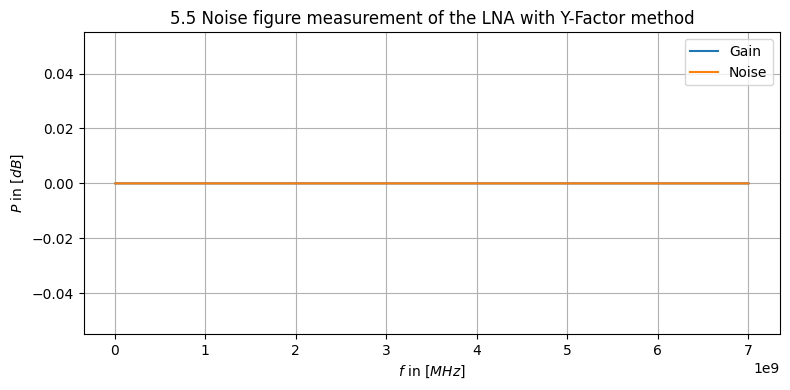

In [65]:
title_y = "5.5 Noise figure measurement of the LNA with Y-Factor method"
plot_compare(x1=f_steps, y1=G1,
             x2=f_steps, y2=NF_1,
             title=title_y, label1="Gain", label2="Noise", 
             marker1=None, marker2=None,
             x_label="$f$ in $[MHz]$",
             y_label="$P$ in $[dB]$")

**Comparison with Task 5.3** <br>

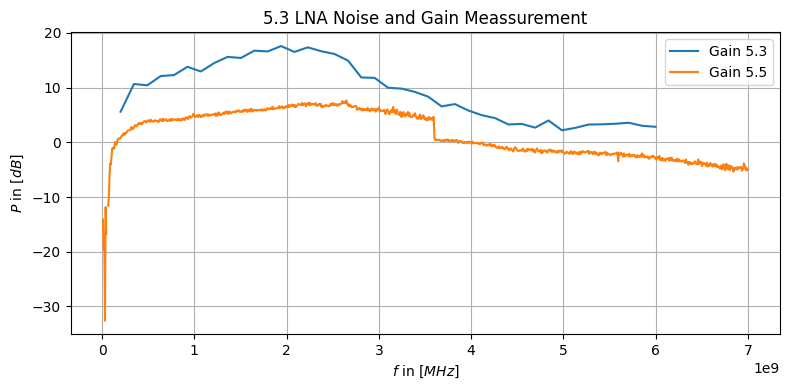

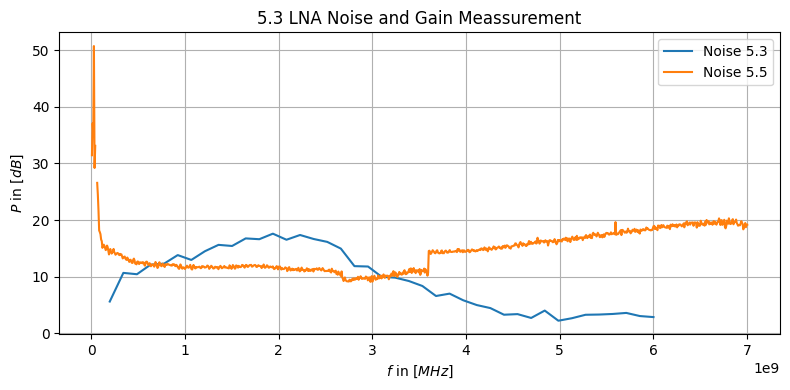

In [66]:
plot_compare(x1=np.multiply(lna_f_steps, 1e6), y1=lna_gain,
             x2=f_steps, y2=G1,
             title=title_lna, label1="Gain 5.3", label2="Gain 5.5", 
             marker1=None, marker2=None,
             x_label="$f$ in $[MHz]$",
            y_label="$P$ in $[dB]$")

plot_compare(x1=np.multiply(lna_f_steps, 1e6), y1=lna_gain,
             x2=f_steps, y2=NF_1,
             title=title_lna, label1="Noise 5.3", label2="Noise 5.5", 
             marker1=None, marker2=None,
             x_label="$f$ in $[MHz]$",
            y_label="$P$ in $[dB]$")

**Evaluation** <br>
As we can see in the results, the meassured $G_1$ and $NF$ is much lower than the internal $G+NF$ meassurement method.

**Reasons for deviations:** <br>
- ENR is frequency dependent and we are using on fixed value across the whole frequency range. This is accomodate for in the internal meassurement method.
- As described in the last section of the theoretical part of the PDF, if $NF > 10dB$ the meassuring system can mask the noise from the DUT and therefore is not accurate. This seems to happen especially above ~$ 3.5GHz$